# EM casing response dipole source

In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [5]:
run_simulations = True
directory = f"{path_to_data}/fields_dipole_fdem"

In [6]:
import os
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 2, 10, 25, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = np.array([casing_b - t for t in casing_t])
casing_l = 500

In [8]:
# diffusion distance
1260 * np.sqrt(1/sigma_back)

3984.469851812158

In [9]:
src_dz = 10
src_z = np.r_[-100, -250, -400, -495, -500, -550, -600]

In [10]:
csz = 2.5
npadz = 17
pf = 1.5

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t.min()/4., 
    npadx=11,
    csx2=25,
    domain_x=500
)

# Theta discretization
ny = 1
hy = np.ones(ny)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = np.max([casing_l, np.max(np.abs(src_z))])/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

30140


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [11]:
frequencies = np.logspace(-1, 3, 41) 
print(frequencies)
print(503/np.sqrt(sigma_back*frequencies))
print(503/np.sqrt(sigma_casing*frequencies))

[1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02
 1.00000000e+03]
[5030.         4482.99221881 3995.47102066 3560.96729545 3173.71544274
 2828.57686571 2520.97178515 2246.81846852 2002.47906788 1784.71134784
 1590.62566306 1417.64661443 1263.47887505 1126.0767327  1003.61694443
  894.47454325  797.20127581  710.50638495  633.23948213  564.37528251
  503.          448.29922188  399.54710207  356.09672955  317.37154427
  282.85768657  25

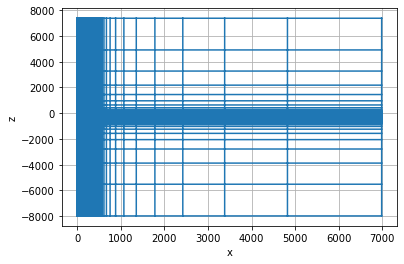

In [12]:
ax = mesh.plot_grid()

In [13]:
def get_casing_inds(ca):
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > ca) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    return inds_casing_x & inds_casing_z

In [14]:
mur_casing

array([  1,   2,  10,  25,  50, 100, 150, 200])

In [15]:
models = {}

halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

models[f"halfspace"] = {
    "sigma": halfspace_conductivity, 
    "mur": np.ones(mesh.n_cells)
} 
    
for i, t in enumerate(casing_t): 
    inds_casing = get_casing_inds(casing_a[i])
    casing_conductivity = halfspace_conductivity.copy()
    casing_conductivity[inds_casing] = sigma_casing

    for mur in mur_casing:
        key = f"casing_{mur:1.0f}_{t:1.2e}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": casing_permeability
        }


In [85]:
for i, t in enumerate(casing_t): 
    inds_casing = get_casing_inds(casing_a[i])

    for mur in mur_casing:
        key = f"permeable_only_{mur:1.0f}_{t:1.2e}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": halfspace_conductivity, 
            "mur": casing_permeability
        }

In [16]:
for i, t in enumerate(casing_t): 
    inds_casing = get_casing_inds(casing_a[i])
    for mur in mur_casing: 
        s_casing = sigma_casing * mur
        key = f"conductive_casing_{s_casing:1.2e}_{t:1.2e}"
        
        casing_conductivity = halfspace_conductivity.copy()
        casing_conductivity[inds_casing] = s_casing
        
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": np.ones_like(casing_conductivity)
        }

In [17]:
def plot_casing(ax, model): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, model, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
#     for sign in np.r_[-1, 1]: 
#         ax.arrow(
#             0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )

#         ax.arrow(
#             0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )
#     ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
#     ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [86]:
models.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_2_5.00e-03', 'casing_10_5.00e-03', 'casing_25_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_2_7.50e-03', 'casing_10_7.50e-03', 'casing_25_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_2_1.00e-02', 'casing_10_1.00e-02', 'casing_25_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_2_1.25e-02', 'casing_10_1.25e-02', 'casing_25_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_2_1.50e-02', 'casing_10_1.50e-02', 'casing_25_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_2_2.00e-02', 'casing_10_2.00e-02', 'casing_25_2.00e-02', 'casi

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


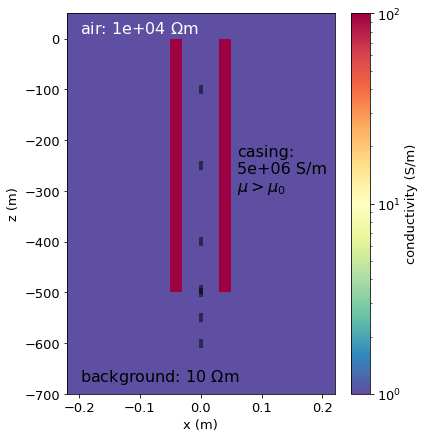

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))

key = "permeable_only_100_2.00e-02"

plot_casing(ax, models[key]["mur"])

for loc in src_z:
    ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [22]:
def generate_simulation(mur):
    src_list = []
    for loc in src_z:
        src_locations = np.array([
            [0, 0, loc+src_dz/2.],
            [0, 0, loc-src_dz/2.]
        ])
        for f in frequencies: 
            src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
            src_list.append(src)
        
    survey = fdem.Survey(src_list)
    sim = fdem.simulation.Simulation3DMagneticField(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, mu=mur * mu_0
    #     verbose=True
    )
    return sim


In [23]:
def load_fields(name, conductivity, mur):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, sim._solutionType] = solution
    return f

In [92]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/frequencies", frequencies)
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [25]:
def run_simulation(key):
    t = time.time()
    print(f"starting {key}\n")
    sim = generate_simulation(models[key]["mur"])
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_{key}", f[:, f"{sim._solutionType}"])
    print(f" ... done {key}. {time.time()-t:1.2e} s")
    return 

In [26]:
def generate_dc_simulation(): 
    src_list = []
    for loc in src_z:
        src_list.append(dc.sources.Dipole([], location_a=[0, 0, loc+src_dz/2.], location_b=[0, 0, loc-src_dz/2.]))
        
    survey = dc.Survey(src_list)
    sim = dc.simulation.Simulation3DCellCentered(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, bc_type="Dirichlet",
    #     verbose=True
    )
    return sim

In [27]:
def load_dc_fields(name, conductivity):
    solution = np.load(f"{directory}/fields_dc_{name}.npy")
    sim = generate_dc_simulation()
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, "phiSolution"] = solution
    return f

In [28]:
def run_dc_simulation(key):
    t = time.time()
    print(f"starting {key}\n")
    sim = generate_dc_simulation()
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_dc_{key}", f[:, f"phi"])
    print(f" ... done {key}. {time.time()-t:1.2e} s")
    return

In [104]:
run_keys = [k for k in models.keys() if not os.path.exists(f"{directory}/fields_{k}.npy")]
print(run_keys)

['permeable_only_2_5.00e-03', 'permeable_only_10_5.00e-03', 'permeable_only_25_5.00e-03', 'permeable_only_50_5.00e-03']


In [105]:
if run_simulations:   
    with Pool(4) as p:
        p.map(run_simulation, run_keys) # list(models.keys()))
# for k in run_keys:
#     run_simulation(k)

starting permeable_only_2_5.00e-03



/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It wi

 ... done permeable_only_2_5.00e-03. 1.54e+01 s
starting permeable_only_10_5.00e-03

 ... done permeable_only_10_5.00e-03. 1.64e+01 s
starting permeable_only_25_5.00e-03

 ... done permeable_only_25_5.00e-03. 1.54e+01 s
starting permeable_only_50_5.00e-03

 ... done permeable_only_50_5.00e-03. 1.54e+01 s


In [106]:
# fields = {}
for key in models.keys():
    if key not in fields.keys():
        fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [33]:
dc_keys = []
for k in models.keys():
    if "conductive_casing" in k:
        dc_keys.append(k)
    elif "casing" in k:
        if int(k.split("_")[1]) == 1:
            dc_keys.append(k)
    else: 
        dc_keys.append(k)

In [34]:
if run_simulations:   
    # with Pool(32) as p:
    #     p.map(run_dc_simulation, dc_keys)
    for k in dc_keys:
        run_dc_simulation(k)

starting halfspace



/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.faceDiv has been deprecated, please use CylindricalMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


 ... done halfspace. 4.97e-01 s
starting casing_1_5.00e-03

 ... done casing_1_5.00e-03. 2.60e-01 s
starting casing_1_7.50e-03

 ... done casing_1_7.50e-03. 2.41e-01 s
starting casing_1_1.00e-02

 ... done casing_1_1.00e-02. 2.80e-01 s
starting casing_1_1.25e-02

 ... done casing_1_1.25e-02. 2.35e-01 s
starting casing_1_1.50e-02

 ... done casing_1_1.50e-02. 1.80e-01 s
starting casing_1_2.00e-02

 ... done casing_1_2.00e-02. 1.87e-01 s
starting conductive_casing_5.00e+06_5.00e-03

 ... done conductive_casing_5.00e+06_5.00e-03. 1.81e-01 s
starting conductive_casing_1.00e+07_5.00e-03

 ... done conductive_casing_1.00e+07_5.00e-03. 1.79e-01 s
starting conductive_casing_5.00e+07_5.00e-03

 ... done conductive_casing_5.00e+07_5.00e-03. 1.81e-01 s
starting conductive_casing_1.25e+08_5.00e-03

 ... done conductive_casing_1.25e+08_5.00e-03. 1.82e-01 s
starting conductive_casing_2.50e+08_5.00e-03

 ... done conductive_casing_2.50e+08_5.00e-03. 1.80e-01 s
starting conductive_casing_5.00e+08_5.00

In [35]:
dc_fields = {}
for key in dc_keys:
    if key not in dc_fields.keys():
        dc_fields[key] = load_dc_fields(key, models[key]["sigma"])

In [36]:
rcParams["font.size"] = 13

In [37]:
fields.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_2_5.00e-03', 'casing_10_5.00e-03', 'casing_25_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_2_7.50e-03', 'casing_10_7.50e-03', 'casing_25_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_2_1.00e-02', 'casing_10_1.00e-02', 'casing_25_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_2_1.25e-02', 'casing_10_1.25e-02', 'casing_25_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_2_1.50e-02', 'casing_10_1.50e-02', 'casing_25_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_2_2.00e-02', 'casing_10_2.00e-02', 'casing_25_2.00e-02', 'casi

In [38]:
src_z

array([-100, -250, -400, -495, -500, -550, -600])

In [39]:
ind_freq_plot = np.r_[0, 10, 20, 30, 35, 40]
frequencies[ind_freq_plot]

array([1.00000000e-01, 1.00000000e+00, 1.00000000e+01, 1.00000000e+02,
       3.16227766e+02, 1.00000000e+03])

In [40]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

def skin_depth_frequency(depth, sigma, mur):
    return 2/(2*np.pi * depth**2 * sigma * mur*mu_0)

In [41]:
mesh.h[0].min()

0.00125

In [42]:
for indf in ind_freq_plot:
    freq = frequencies[indf]
    print(f"{freq:5.1f} Hz:    {skin_depth(freq, sigma_casing, mur_casing)}")

  0.1 Hz:    [0.71176254 0.50329212 0.22507908 0.14235251 0.10065842 0.07117625
 0.05811517 0.05032921]
  1.0 Hz:    [0.22507908 0.15915494 0.07117625 0.04501582 0.03183099 0.02250791
 0.01837763 0.01591549]
 10.0 Hz:    [0.07117625 0.05032921 0.02250791 0.01423525 0.01006584 0.00711763
 0.00581152 0.00503292]
100.0 Hz:    [0.02250791 0.01591549 0.00711763 0.00450158 0.0031831  0.00225079
 0.00183776 0.00159155]
316.2 Hz:    [0.01265713 0.00894994 0.00400253 0.00253143 0.00178999 0.00126571
 0.00103345 0.00089499]
1000.0 Hz:    [0.00711763 0.00503292 0.00225079 0.00142353 0.00100658 0.00071176
 0.00058115 0.00050329]


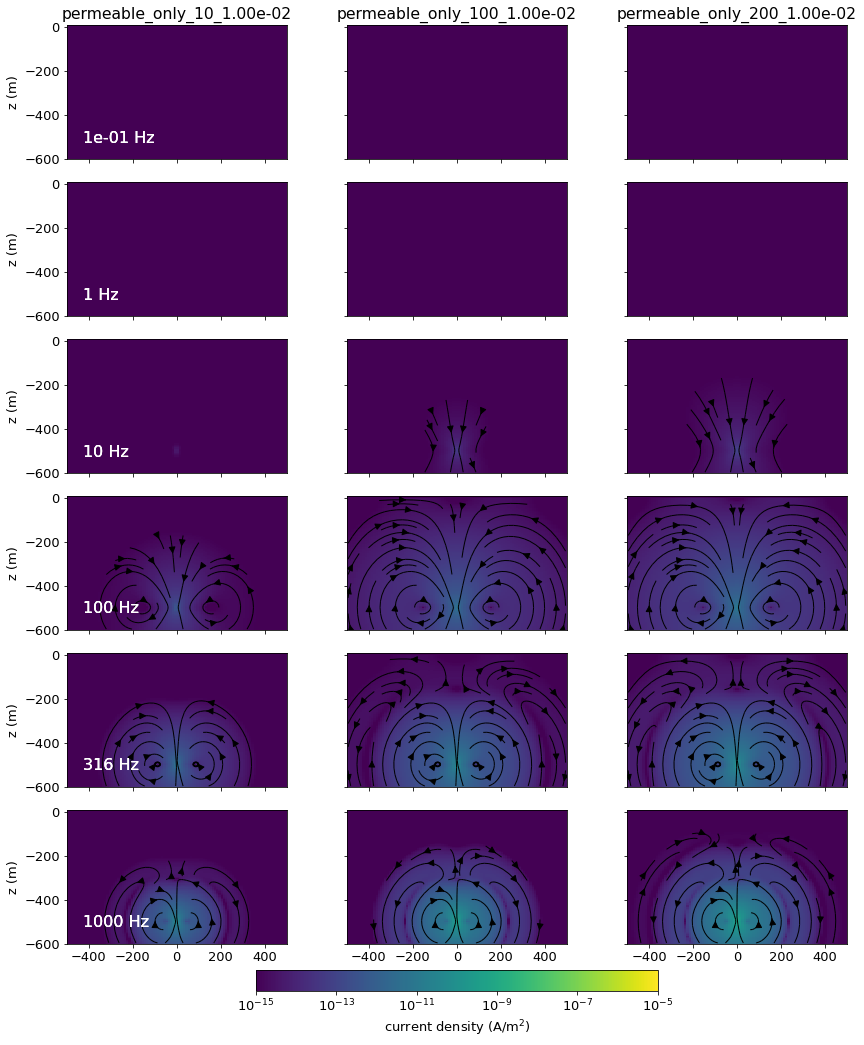

In [117]:
plot_t = 10e-03
plot_mur = np.r_[10, 100, 200]
plot_keys = [f"permeable_only_{mur}_{plot_t:1.2e}" for mur in plot_mur] # ["halfspace", "casing_1", "casing_200"]

primary_key = "halfspace" 
primsec="secondary" 

fig, ax = plt.subplots(
    len(ind_freq_plot), len(plot_keys), 
    figsize=(4*len(plot_keys), (len(ind_freq_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "real" 
xlim= 500 * np.r_[-1, 1]
zlim=np.r_[-600, 10]
clim = np.r_[1e-15, 1e-5]
src_ind = 4

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts,
            primary_fields=fields[primary_key], 
            prim_sec=primsec,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [44]:
sigma_casing

5000000.0

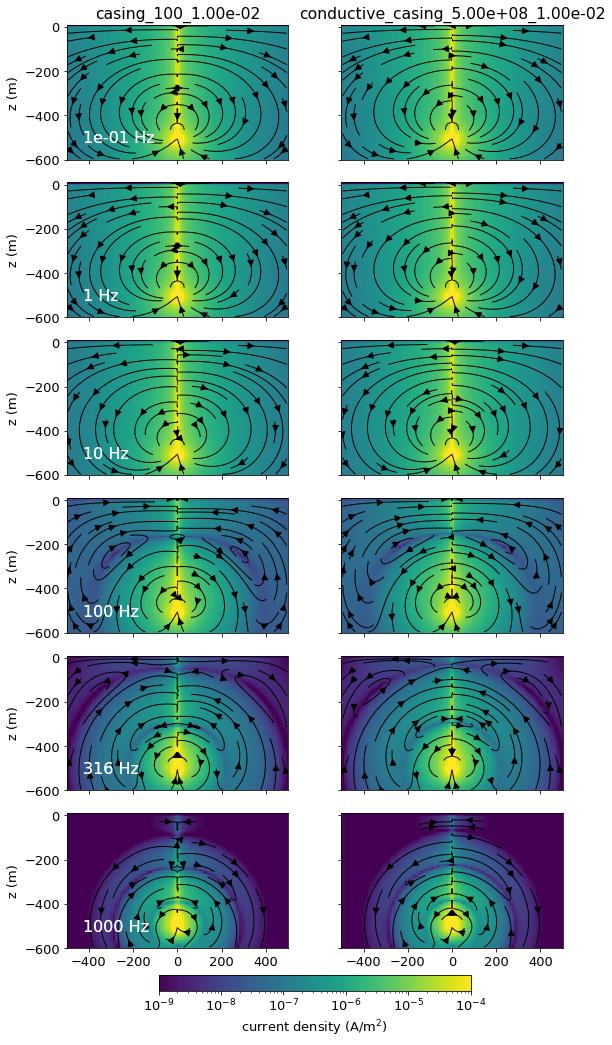

In [45]:
plot_t = 10e-03
plot_mur = 100
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]

fig, ax = plt.subplots(
    len(ind_freq_plot), len(plot_keys), 
    figsize=(4*len(plot_keys), (len(ind_freq_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "real" 
xlim= 500 * np.r_[-1, 1]
zlim=np.r_[-600, 10]
clim = np.r_[1e-9, 1e-4]
src_ind = 4

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

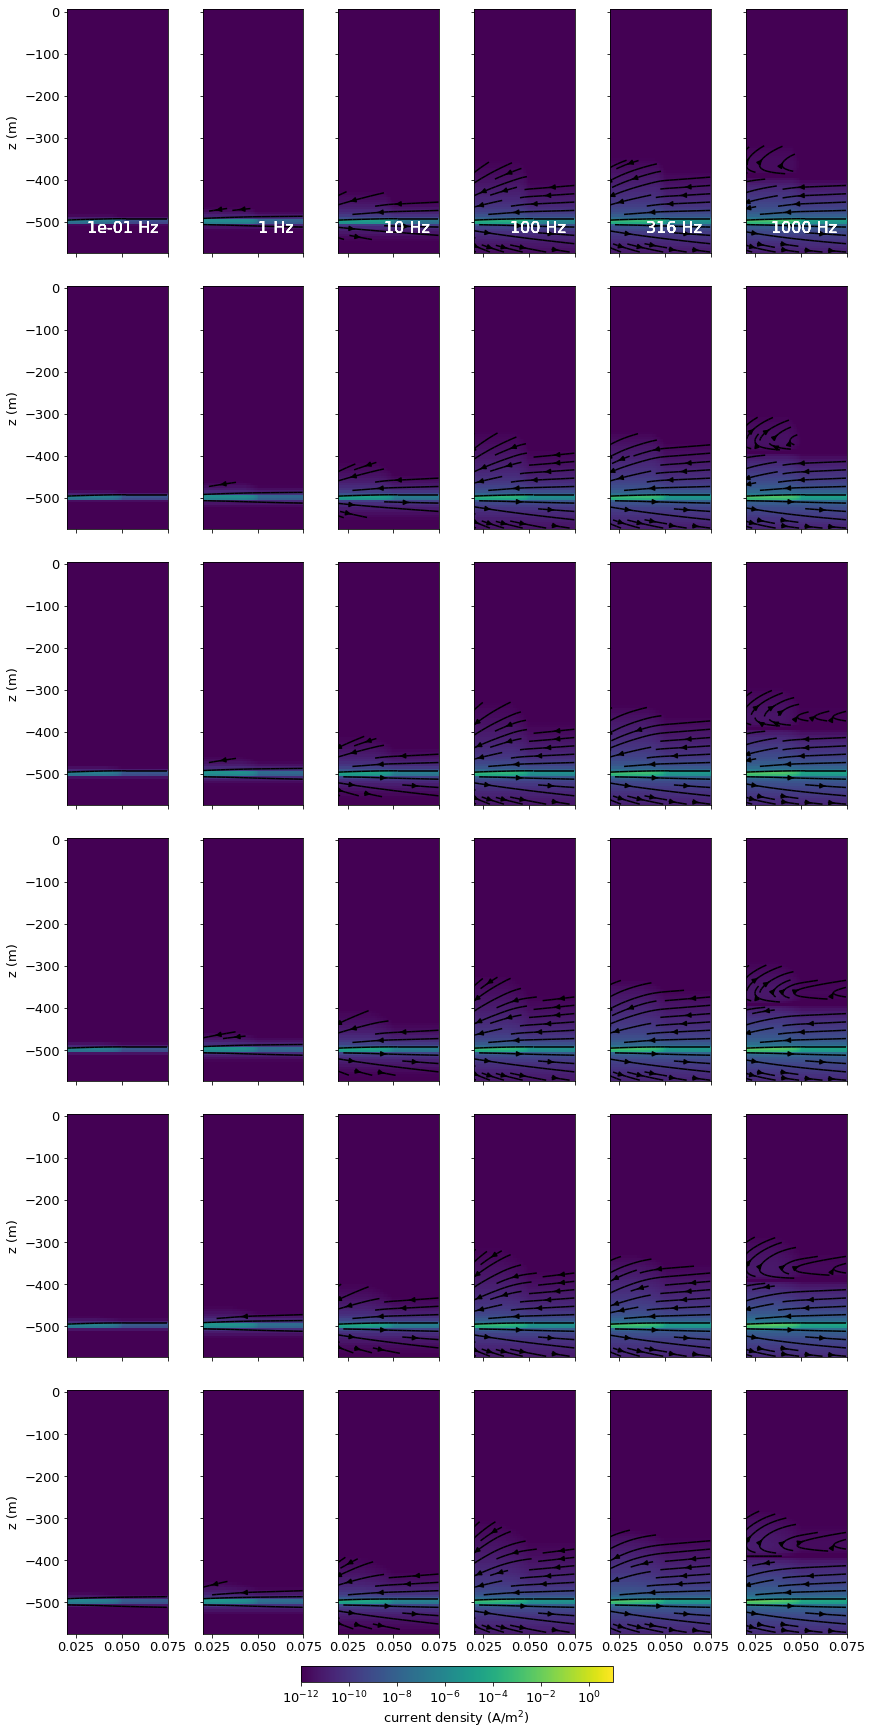

In [115]:
plot_t = casing_t
plot_mur = 200
plot_keys = [f"permeable_only_{plot_mur}_{t:1.2e}" for t in plot_t] # ["halfspace", "casing_1", "casing_200"]
primary_key = "halfspace" 
primsec="total" 
fig, ax = plt.subplots(
    len(plot_keys), len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, len(plot_keys)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 4
reim = "imag"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-12, 1e1]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(plot_keys):
    f = fields[key]
    
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            primary_fields=fields[primary_key], 
            prim_sec=primsec,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


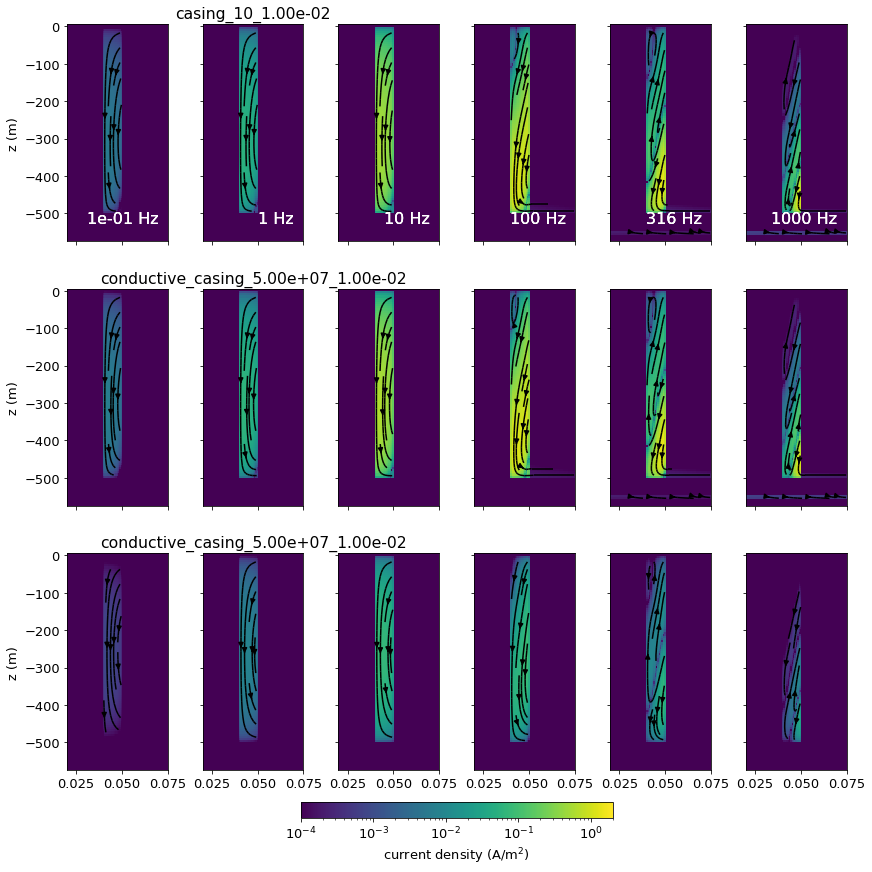

In [49]:
plot_t = 10e-03
plot_mur = 10
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]
fig, ax = plt.subplots(
    len(plot_keys)+1, len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, (len(plot_keys)+1)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 5
reim = "imag"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-4, 2]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

for i in range(len(plot_keys)+1):
    if i < len(plot_keys):
        key = plot_keys[i]
        primsec = "total"
    else:
        key = plot_keys[-1]
        primsec = "secondary"
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            fields[key],
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            primary_fields=fields[plot_keys[0]], 
            prim_sec=primsec,
            # stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    ax[i, 1].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


In [50]:
skin_depth(1, 5e6, 100)

0.022507907897801275

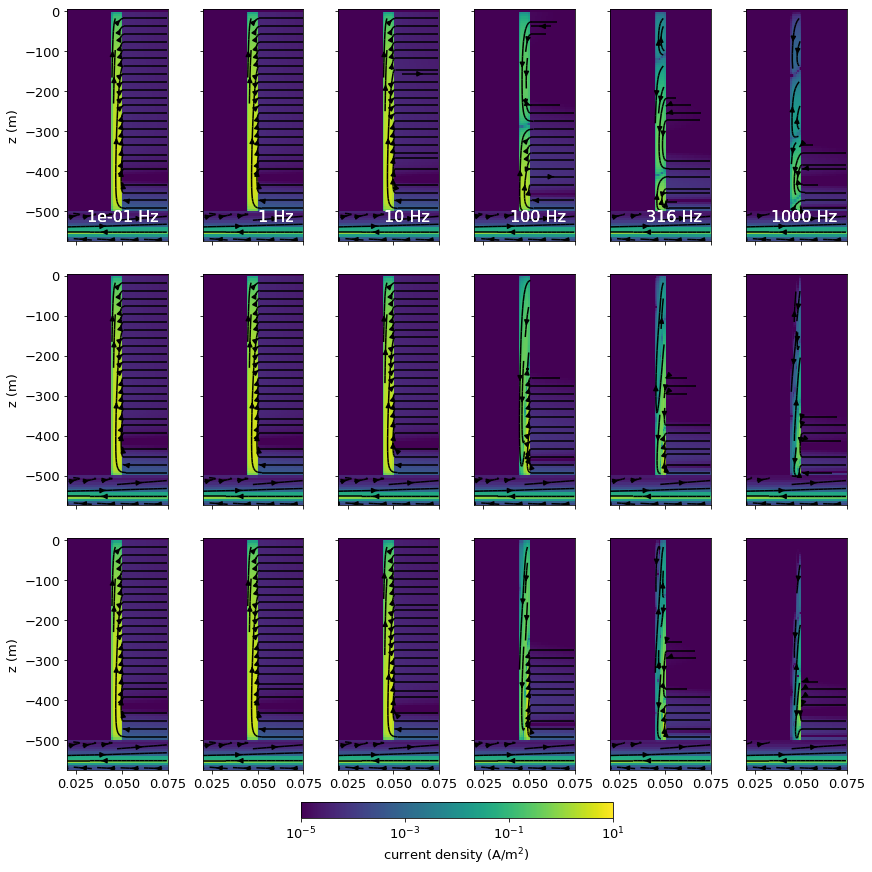

In [51]:
plot_t = 5e-03
plot_mur = np.r_[1, 100, 200]
plot_keys = [f"casing_{mur}_{plot_t:1.2e}" for mur in plot_mur] # ["halfspace", "casing_1", "casing_200"]

fig, ax = plt.subplots(
    len(plot_keys), len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, len(plot_keys)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 5
reim = "real"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-5, 1e1]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(plot_keys):
    f = fields[key]
    
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            # stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


In [52]:
def plot_cross_section_field(
    key, field, src_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    prime_sec="total", primary_field=None, primary_src_ind=None,  
    log_scale=False, eps=1e-15, vmin=None, clim=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
    src = fields[key].survey.source_list[src_ind]    
    field_plot = ave * getattr(fields[key][src, field], real_or_imag)
    
    if prime_sec in ["secondary", "percent", "primary"]:
        if primary_src_ind is None: 
            primary_src_ind = src_ind
        primary_src = primary_field.survey.source_list[primary_src_ind] 
        primary = ave * getattr(primary_field[primary_src, field], real_or_imag)
        if prime_sec == "primary": 
            field_plot = primary
        else: 
            field_plot = field_plot - primary
            if prime_sec == "percent":
                field_plot = dfield_plot / np.abs(primary + eps) * 100

    components = ["x", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = discretize.utils.mkvc(fieldi)

    # plot x,z vector
    fieldxz = np.hstack([field_components[c]for c in ["x", "z"]])

    sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

    vmax = clim.max() if clim is not None else None
    if log_scale is True: 
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else: 
        norm = Normalize(0, vmax)
    out = mesh2d.plot_image(
        fieldxz, v_type="CCv", view="vec", ax=ax,
        range_x=xlim, range_y=zlim,
        sample_grid=sample_grid,
        mirror=True,
        pcolor_opts={"norm":norm},
        stream_threshold=vmin,
    )
    plt.colorbar(out[0], ax=ax)
    return ax

In [53]:
plot_keys

['casing_1_5.00e-03', 'casing_100_5.00e-03', 'casing_200_5.00e-03']

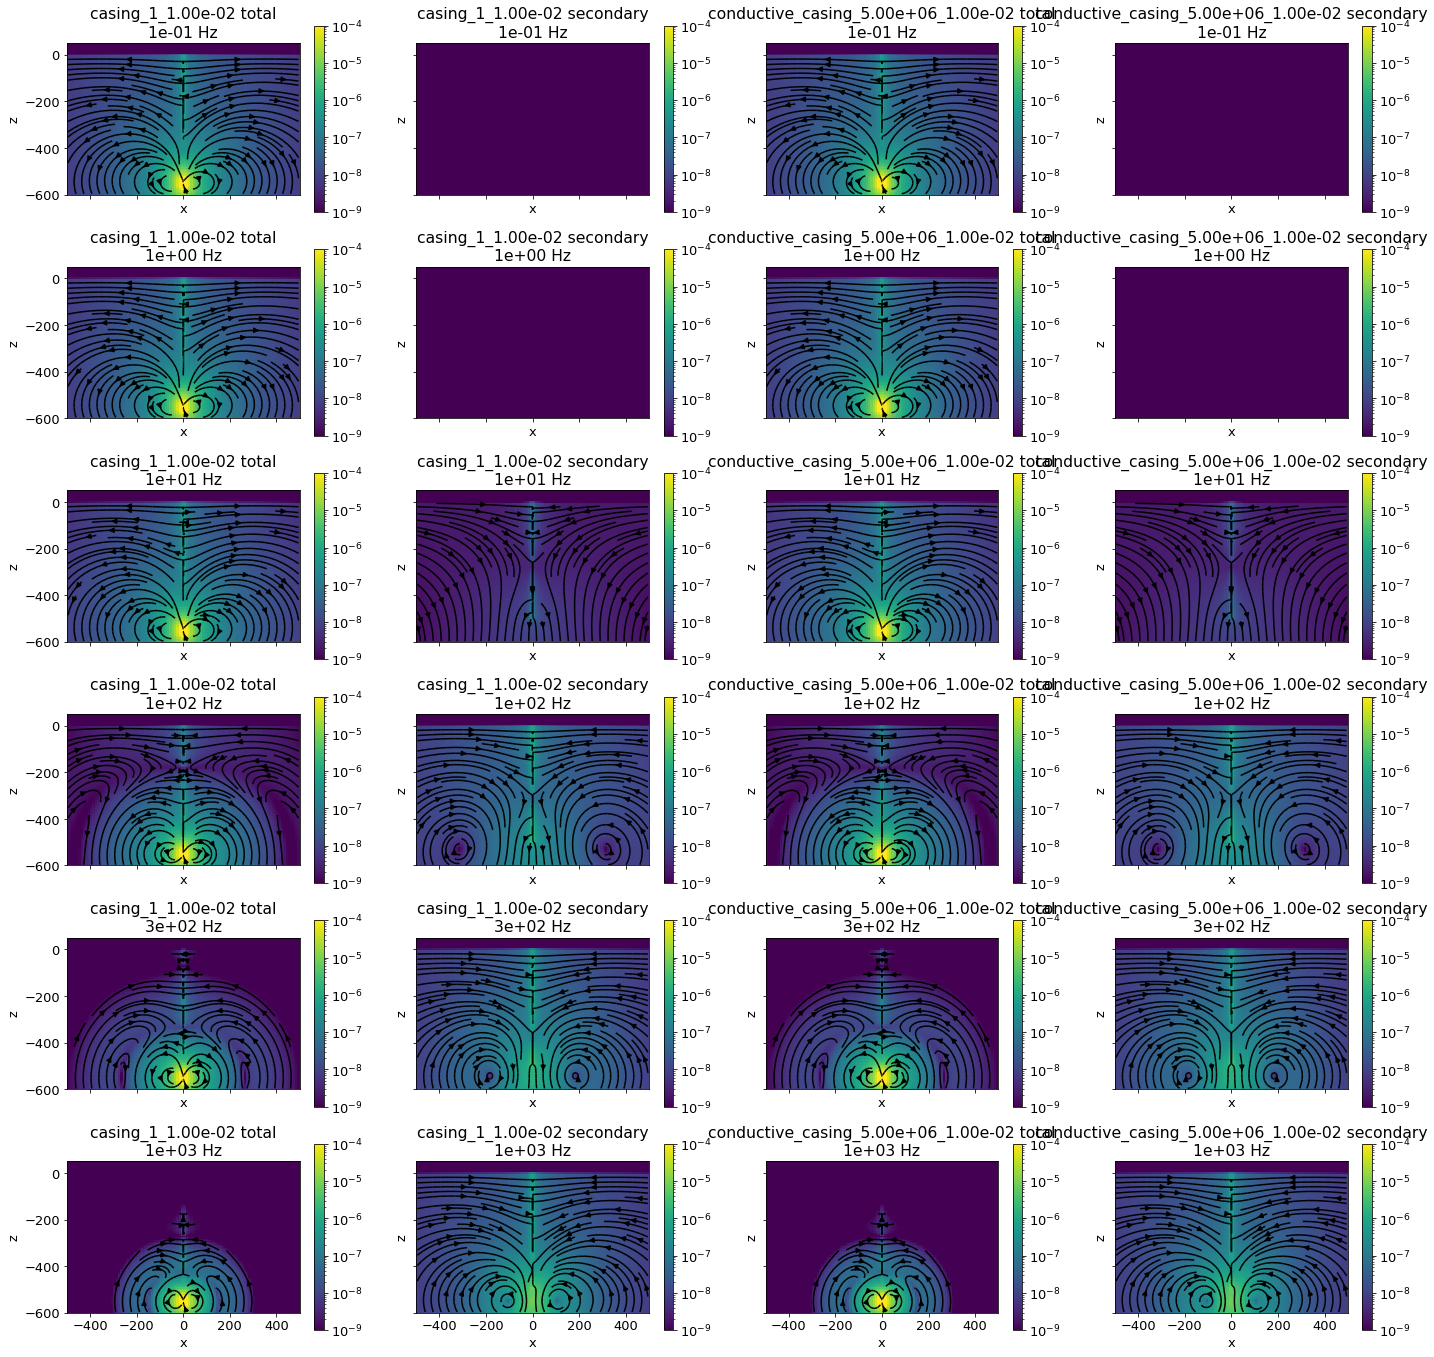

In [54]:
fig, ax = plt.subplots(
    len(ind_freq_plot), 4, figsize=(24, 4*len(ind_freq_plot)), sharex=True, sharey=True
)

plot_t = 10e-03
plot_mur = 1
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]
primary_keys = [f"casing_1_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]
src_ind=5

for i, indf in enumerate(ind_freq_plot):
    for j, key in enumerate(plot_keys):
        primary = dc_fields[primary_keys[j]]
        for k, primsec in enumerate(["total", "secondary"]):
            plot_cross_section_field(
                key, "j", ax=ax[i,j*2+k], 
                xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
                primary_field=primary, 
                real_or_imag = "real", 
                prime_sec=primsec, 
                log_scale=True,
                src_ind=src_ind*len(frequencies) + indf,
                vmin=1e-9,
                primary_src_ind=src_ind,
                clim=np.r_[1e-10, 1e-4]
            )
            ax[i, j*2+k].set_title(f"{key} {primsec}\n{frequencies[indf]:1.0e} Hz")
    
for a in ax.flatten():
    a.set_aspect(1)

50 0.01


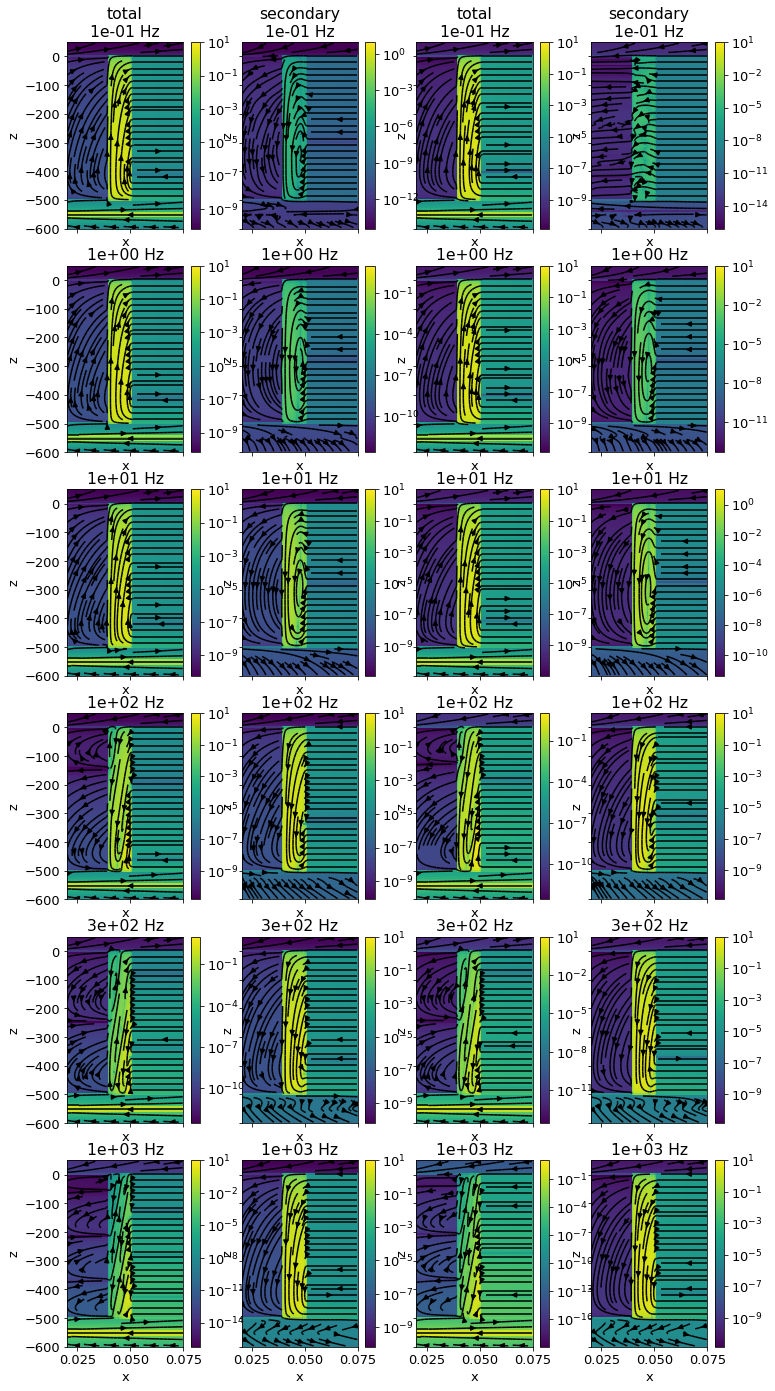

In [82]:
fig, ax = plt.subplots(
    len(ind_freq_plot), 4, figsize=(12, 4*len(ind_freq_plot)), sharex=True, sharey=True
)

plot_t = 10e-03
plot_mur = 50
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]
primary_keys = [f"casing_1_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.2e}_{plot_t:1.2e}"]
src_ind=5

for i, indf in enumerate(ind_freq_plot):
    for j, key in enumerate(plot_keys):
        primary = dc_fields[primary_keys[j]]
        for k, primsec in enumerate(["total", "secondary"]):
            plot_cross_section_field(
                key, "j", ax=ax[i,j*2+k], 
                xlim=np.r_[0.02, 0.075], zlim=np.r_[-600, 50],
                primary_field=primary, 
                real_or_imag = "real", 
                prime_sec=primsec, 
                log_scale=True,
                src_ind=src_ind*len(frequencies) + indf,
                primary_src_ind=src_ind,
                clim=np.r_[1e-8, 1e1]
            )
            
            if i > 0:
                ax[i, j*2+k].set_title(f"{frequencies[indf]:1.0e} Hz")
            else:
                ax[i, j*2+k].set_title(f"{primsec}\n{frequencies[indf]:1.0e} Hz")
print(plot_mur, plot_t) 

## Plot data

In [56]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", ls=None, color=None, marker=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
        
        if ls is None:
            pos_ls = "-"
            neg_ls = "--"
        else:
            pos_ls = "-."
            neg_ls = ":"
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), neg_ls, marker=marker, color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, pos_ls, marker=marker, color=color, label=label)
                label=None
        return ax

In [57]:
fields.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_2_5.00e-03', 'casing_10_5.00e-03', 'casing_25_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_2_7.50e-03', 'casing_10_7.50e-03', 'casing_25_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_2_1.00e-02', 'casing_10_1.00e-02', 'casing_25_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_2_1.25e-02', 'casing_10_1.25e-02', 'casing_25_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_2_1.50e-02', 'casing_10_1.50e-02', 'casing_25_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_2_2.00e-02', 'casing_10_2.00e-02', 'casing_25_2.00e-02', 'casi

In [58]:
xlocs = np.r_[78, 79, 80]
mesh.nodes_x[xlocs]

array([ 75., 100., 125.])

In [59]:
zloc = -csz/2

face_inds = np.zeros_like(xlocs)
for i, xl in enumerate(xlocs): 
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
    )[0][0]
print(mesh.faces_x[face_inds, :])

[[ 75.     0.    -1.25]
 [100.     0.    -1.25]
 [125.     0.    -1.25]]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [60]:
def get_amplitude_phase(f):
    real = f.real
    imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

# Plot as a function of frequency

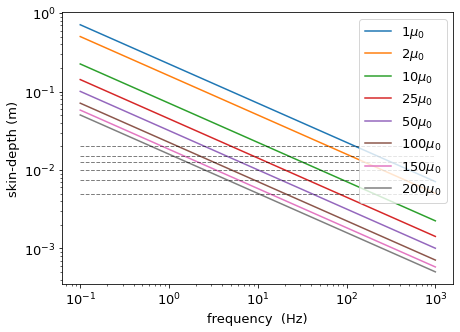

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for mur in mur_casing:
    ax.loglog(frequencies, skin_depth(frequencies, sigma_casing, mur), label=f"{mur}$\mu_0$") 

for t in casing_t:
    ax.loglog(frequencies, t*np.ones_like(frequencies), "--", alpha=0.5, color="k", lw=1)
ax.set_xlabel("frequency  (Hz)")
ax.set_ylabel("skin-depth (m)")
ax.legend()

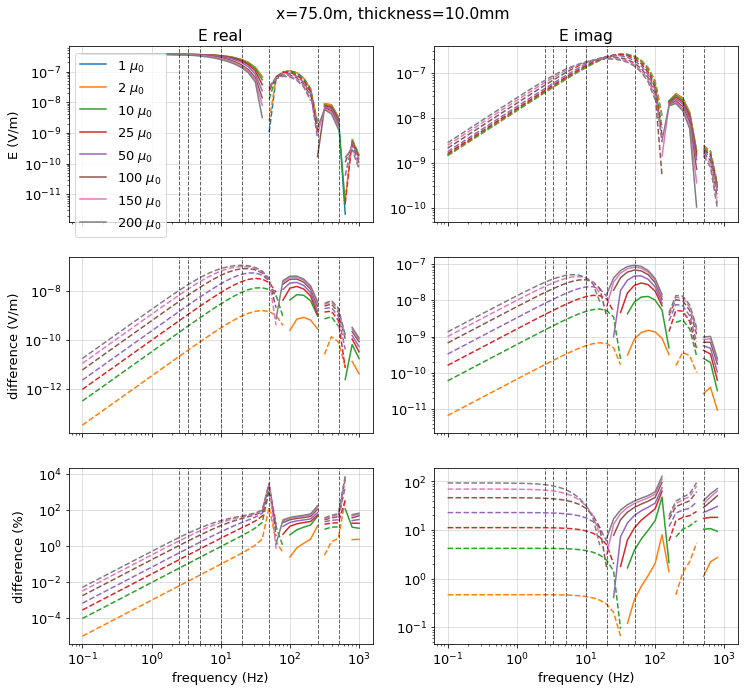

In [62]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

fi = 0
src_ind = 5
t_plot = 10e-3
primary_key = f"casing_1_{t_plot:1.2e}"
mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_inds[fi]][inds_src]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_inds[fi]][inds_src]
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)

for a in ax.flatten():
    a.grid("both", alpha=0.5)
    [a.axvline(skin_depth_frequency(t_plot, sigma_casing, mur), ls="--", color="k", lw=1, alpha=0.6) for mur in mur_casing]

    
ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_inds[fi], 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")
    
ax[0, 0].legend(loc=0)

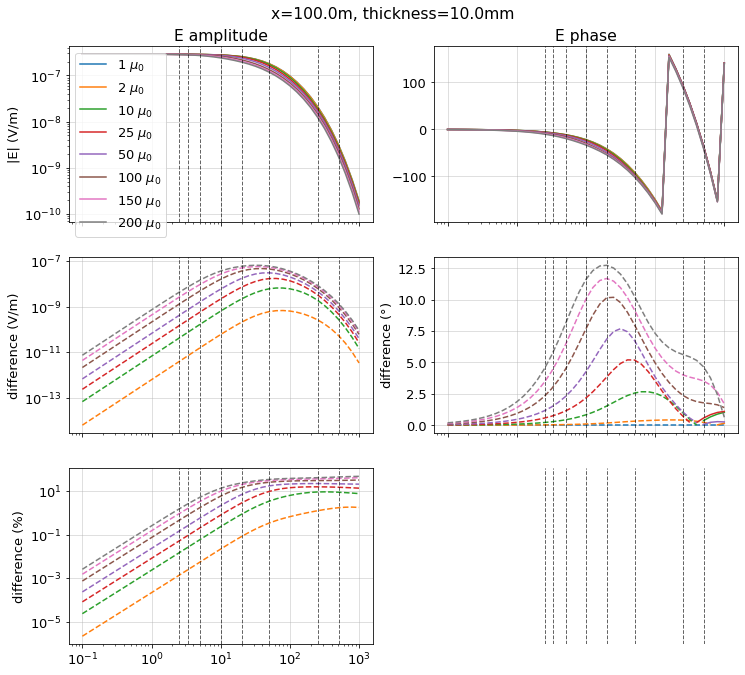

In [63]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

fi = 1
face_ind = face_inds[fi]

src_ind = 5
t_plot = 10e-3
primary_key = f"casing_1_{t_plot:1.2e}"
mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]
a_primary, p_primary = get_amplitude_phase(primary)

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/np.abs(a_primary)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
    [a.axvline(skin_depth_frequency(t_plot, sigma_casing, mur), ls="--", color="k", lw=1, alpha=0.6) for mur in mur_casing]
ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

In [1]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

fi = 1
face_ind = face_inds[fi]

src_ind = 5
reference_t = casing_t.max()
mur_plot = 100 
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    total = fields[key][:, "e"][face_ind][inds_src]
    diff = total - primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")
    
ax[0, 0].legend(loc=0)

NameError: name 'plt' is not defined

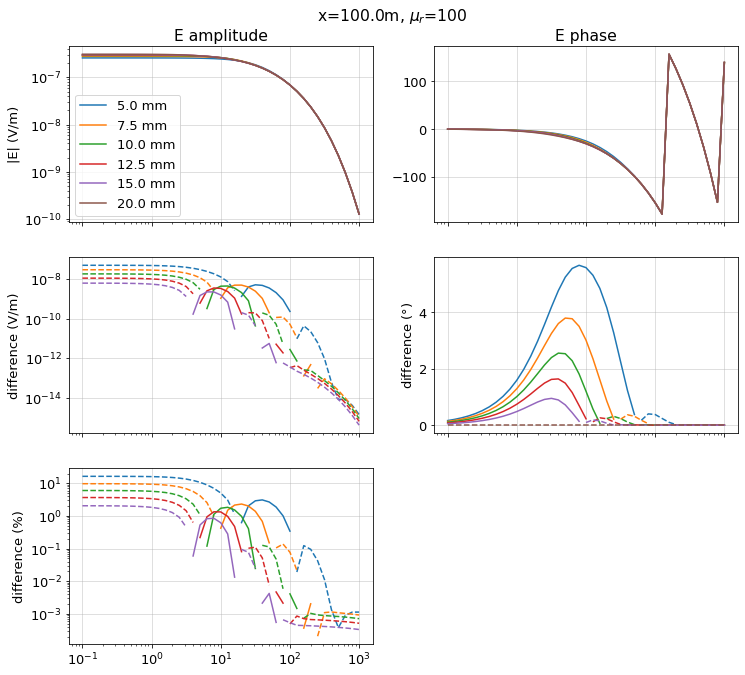

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
reference_t = casing_t.max()
mur_plot = 100 
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]
a_primary, p_primary = get_amplitude_phase(primary)

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

## preserve conductivity thickness product 

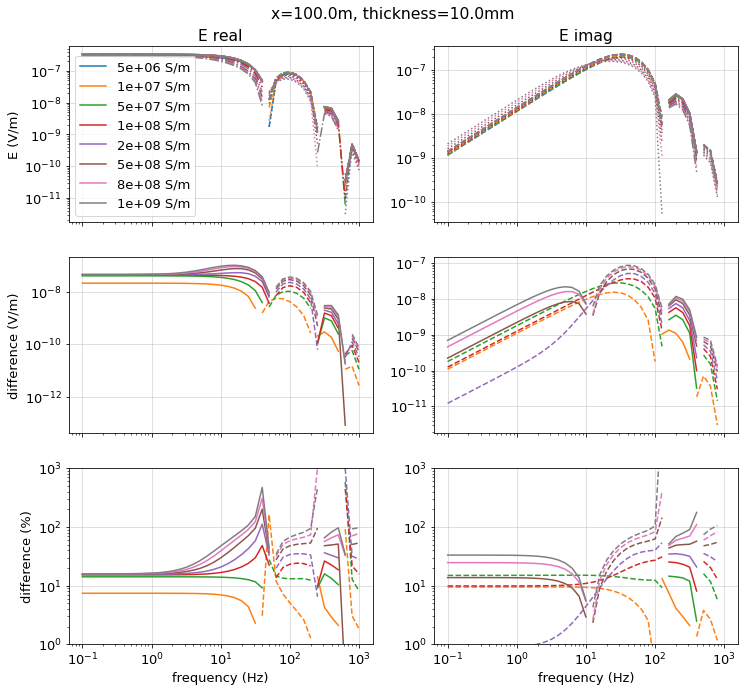

In [66]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3

mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, mur in enumerate(mur_casing): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.2e}_{t_plot:1.2e}"

    primary = fields[primary_key][:, "e"][face_ind][inds_src]
    total = fields[key][:, "e"][face_ind][inds_src]
    diff = total - primary

    label = f"{mur*sigma_casing:1.0e} S/m"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, primary.real, ax[0, 0], plot_type="loglog", color=f"C{i}", ls="alternate")
    plot_pos_neg_log(frequencies, primary.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", ls="alternate")

    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)

    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)

for a in ax.flatten():
    a.grid("both", alpha=0.5)

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")

for a in ax[2, :]:
    a.set_ylim(1, 1e3)
    
ax[0, 0].legend(loc=0)

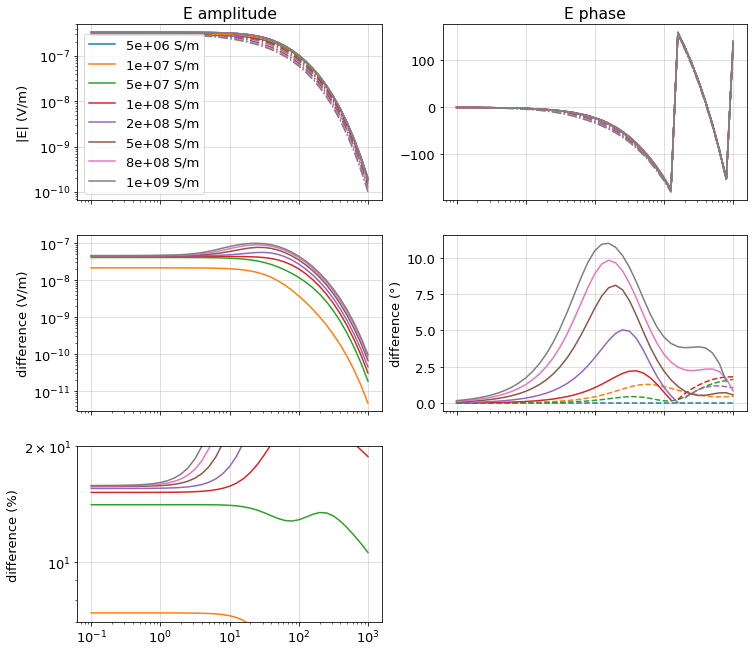

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3

fi = 1
face_ind = face_inds[fi]

mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, mur in enumerate(mur_casing): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.2e}_{t_plot:1.2e}"

    primary = fields[primary_key][:, "e"][face_ind][inds_src]
    a_primary, p_primary = get_amplitude_phase(primary) 

    label = f"{mur*sigma_casing:1.0e} S/m"
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    ax[0, 0].loglog(frequencies, a_primary, color=f"C{i}", ls="-.")
    ax[0, 1].semilogx(frequencies, p_primary, color=f"C{i}", ls="-.")
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
ax[2, 1].axis("off")

ax[2, 0].set_ylim(7, 20)

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
# fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

# Plot as a function of x

In [68]:
zloc = -csz/2
faces_perpendicular = np.where(
    (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
)[0]

In [69]:
frequencies[10]

1.0

10.0


Text(0.5, 0, 'x (m)')

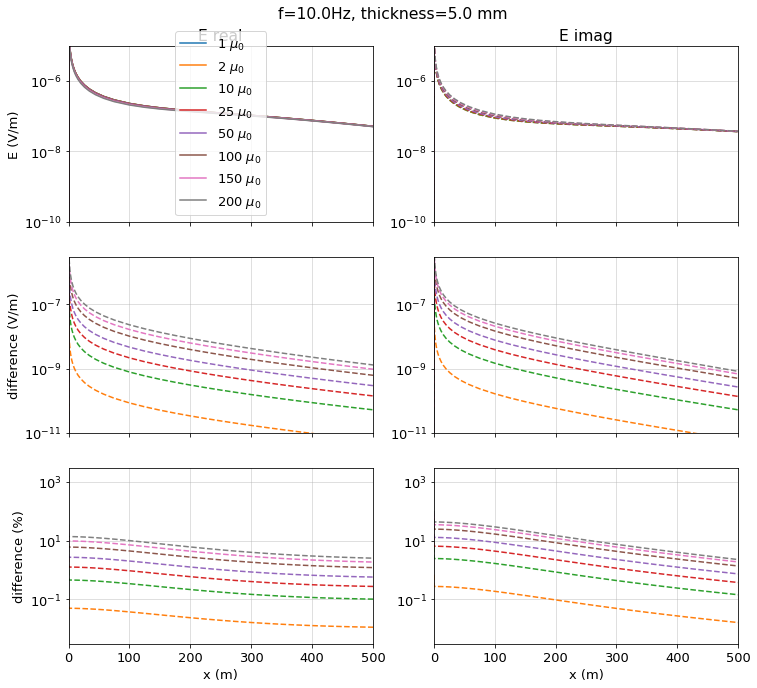

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

print(frequencies[freq_ind])

t_plot = 5e-3
mur_plot = mur_casing
primary_key = f"casing_1_{t_plot:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    plot_pos_neg_log(mesh.nodes_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 500])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax[0, :].flatten():
    a.set_ylim([1e-10, 1e-5])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-11, 3e-6])

for a in ax[2, :].flatten():
    a.set_ylim([3e-3, 3e3])

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, thickness={t_plot*1e3:1.1f} mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].set_xlabel("x (m)")

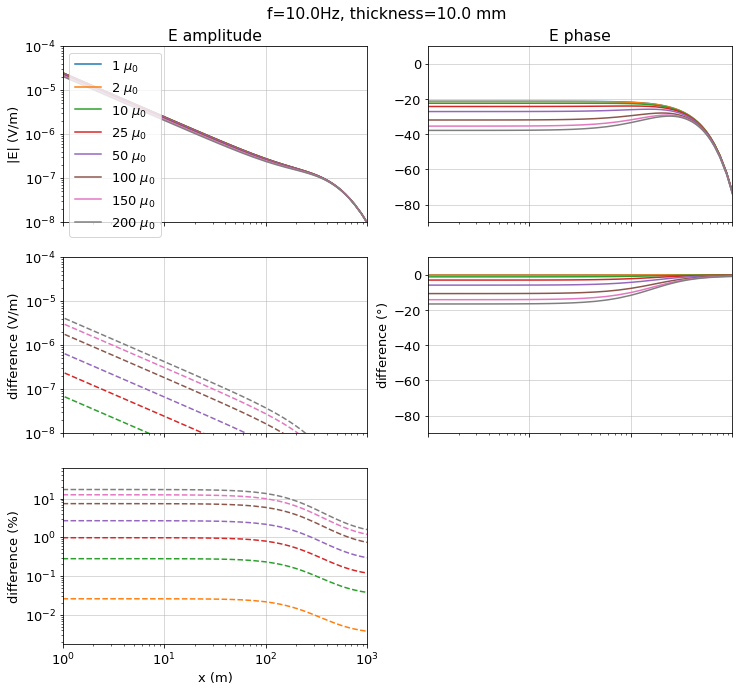

In [71]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

t_plot = 10e-3
mur_plot = mur_casing
primary_key = f"casing_1_{t_plot:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()
a_primary, p_primary = get_amplitude_phase(primary)

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    a_total, p_total = get_amplitude_phase(total) 
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    ax[0, 0].loglog(mesh.nodes_x[1:], a_total[1:], color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total[1:], color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:], ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff[1:], color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:]/a_primary[1:]*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)
 
ax[0, 0].set_xlim([1e0, 1e3])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.6)

for a in ax[:2, 0]:
    a.set_ylim(1e-8, 1e-4)
for a in ax[:2, 1]:
    a.set_ylim(-90, 10)


ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, thickness={t_plot*1e3:1.1f} mm", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].axis("off");

Text(0.5, 0, 'x (m)')

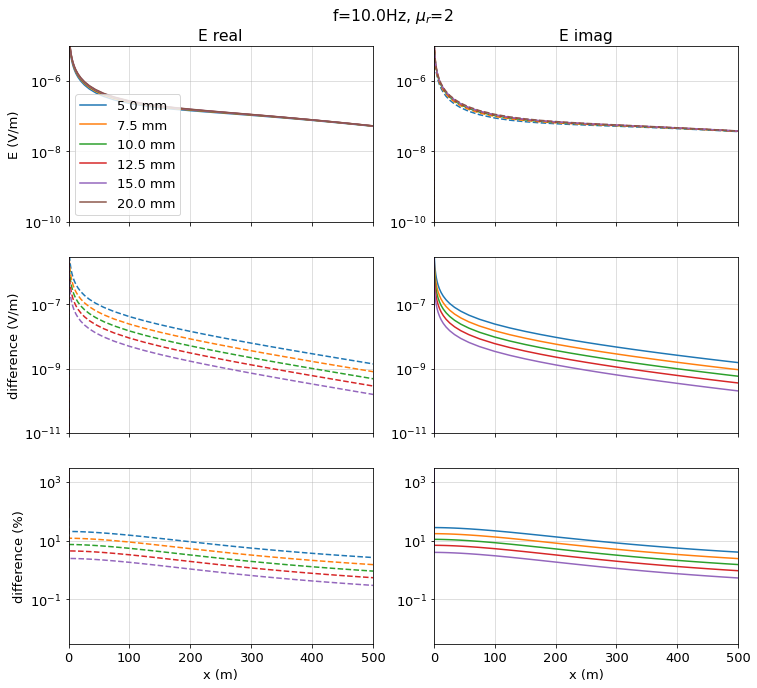

In [72]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 2
freq_ind = 20
src_ind = 5

reference_t = casing_t.max()
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    
    plot_pos_neg_log(mesh.nodes_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 500])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax[0, :].flatten():
    a.set_ylim([1e-10, 1e-5])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-11, 3e-6])

for a in ax[2, :].flatten():
    a.set_ylim([3e-3, 3e3])
    

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].set_xlabel("x (m)")

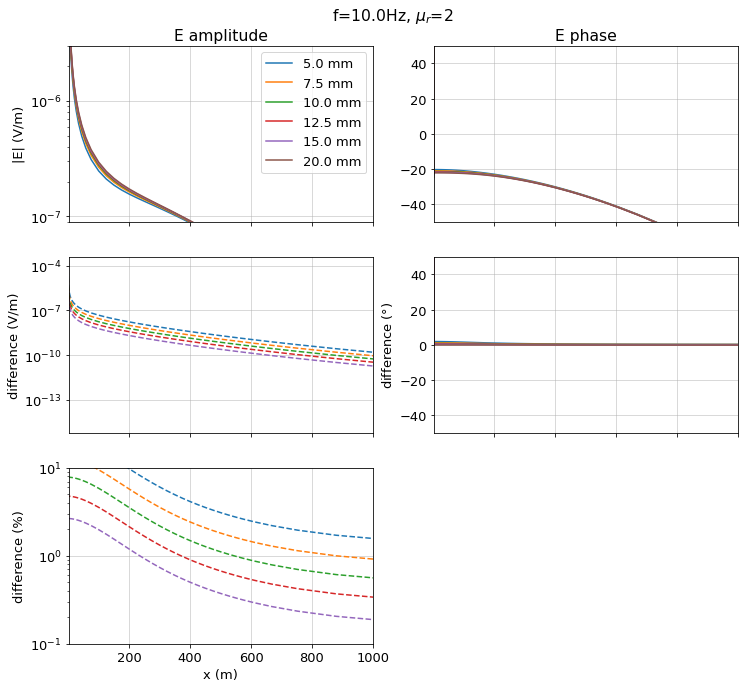

In [77]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 2
freq_ind = 20
src_ind = 5

reference_t = casing_t.max()
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

a_primary, p_primary = get_amplitude_phase(primary)

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    a_total, p_total = get_amplitude_phase(total) 
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    
    ax[0, 0].semilogy(mesh.nodes_x[1:], a_total[1:], color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total[1:], color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:], ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff[1:], color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:]/a_primary[1:]*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)
 
ax[0, 0].set_xlim([1e0, 1e3])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.6)

ax[0, 0].set_ylim(9e-8, 3e-6)
# for a in ax[:2, 0]:
#     a.set_ylim(1e-8, 1e-4)
# for a in ax[:2, 1]:
#     a.set_ylim(-90, 10)

ax[2, 0].set_ylim(1e-1, 1e1)
for a in ax[:, 1]:
    a.set_ylim([-50, 50])

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].axis("off");

In [74]:
frequencies[20]

10.0

Text(0.5, 0, 'x (m)')

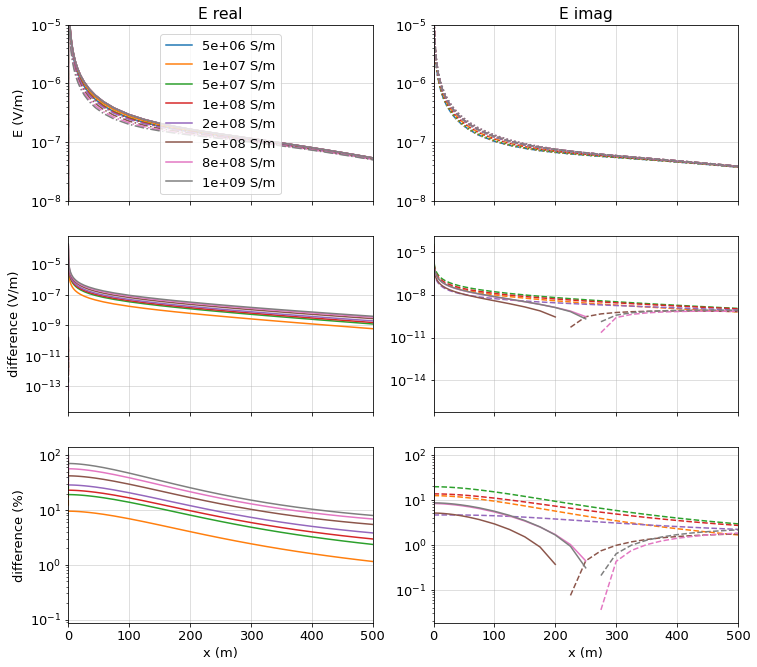

In [75]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3
freq_ind = 20

mur_plot = mur_casing
src_ind = src_ind*len(frequencies) + freq_ind

for i, mur in enumerate(mur_casing): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.2e}_{t_plot:1.2e}"

    primary_src = fields[primary_key].survey.source_list[src_ind]
    src = fields[key].survey.source_list[src_ind]
    
    primary = (fields[primary_key][primary_src, "e"][faces_perpendicular]).squeeze()
    total = (fields[key][src, "e"][faces_perpendicular]).squeeze()
    diff = total - primary
    
    label = f"{mur*sigma_casing:1.0e} S/m"
    
    plot_pos_neg_log(mesh.nodes_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x, primary.real, ax[0, 0], plot_type="semilogy", ls="alternate", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, primary.imag, ax[0, 1], plot_type="semilogy", ls="alternate", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 500])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax[0, :].flatten():
    a.set_ylim([1e-8, 1e-5])
    
# for a in ax[1, :].flatten():
#     a.set_ylim([1e-11, 3e-6])

# for a in ax[2, :].flatten():
#     a.set_ylim([3e-3, 3e3])
    

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
# fig.suptitle(f"f={frequencies[freq_ind]}Hz, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].set_xlabel("x (m)")

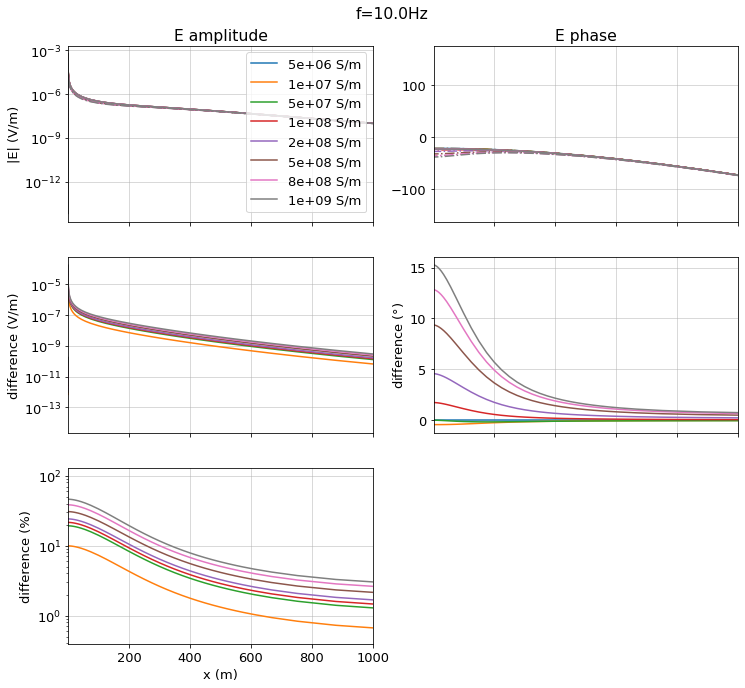

In [78]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3
freq_ind = 20

mur_plot = mur_casing
src_ind = src_ind*len(frequencies) + freq_ind

for i, mur in enumerate(mur_casing): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.2e}_{t_plot:1.2e}"

    primary_src = fields[primary_key].survey.source_list[src_ind]
    src = fields[key].survey.source_list[src_ind]
    
    primary = (fields[primary_key][primary_src, "e"][faces_perpendicular]).squeeze()
    total = (fields[key][src, "e"][faces_perpendicular]).squeeze()
    
    a_total, p_total = get_amplitude_phase(total)
    a_primary, p_primary = get_amplitude_phase(primary) 

    label = f"{mur*sigma_casing:1.0e} S/m"
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    ax[0, 0].semilogy(mesh.nodes_x[1:], a_total[1:], color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total[1:], color=f"C{i}", label=label)
    
    ax[0, 0].semilogy(mesh.nodes_x[1:], a_primary[1:], color=f"C{i}", ls="-.")
    ax[0, 1].plot(mesh.nodes_x[1:], p_primary[1:], color=f"C{i}", ls="-.")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:], ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff[1:], color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:]/a_primary[1:]*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)

ax[0, 0].set_xlim([1e0, 1e3])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.6)

# ax[0, 0].set_ylim(9e-8, 3e-6)
# for a in ax[:2, 0]:
#     a.set_ylim(1e-8, 1e-4)
# for a in ax[:2, 1]:
#     a.set_ylim(-90, 10)

# ax[2, 0].set_ylim(1e-1, 1e1)
# for a in ax[:, 1]:
#     a.set_ylim([-50, 50])

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"f={frequencies[freq_ind]}Hz", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].axis("off");